In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.signal as sps
import scipy.stats as stats
import pickle
# from datetime import datetime as dt
import datetime
from datetime import datetime, timedelta
import time
import seaborn as sns
import csv
import os
import warnings
import h5py as h5
import calendar
# %matplotlib notebook
sns.set()

In [2]:
def toYearFraction(date):
    '''
    Function to convert a datetime to decimal date
    '''
    def sinceEpoch(date): # returns seconds since epoch
        return calendar.timegm(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [3]:
daily_df = pd.read_pickle('SP_dailyMET_df.pkl')
monthly_df = pd.read_pickle('SP_monthlyMET_df.pkl')

In [4]:
'''
This function comes up with the number to use for each day of the year (DOY) to scale the t air by.
I used the RACMO t2m and tskin fields for South Pole to come up with it. 
Tsnow[DOY] = tscaler(DOY)*Tair[DOY]
'''
def tscaler(doy):
    a = -5.70493675e-03
    b = 1.72479759e-02
    c = 3.60427452e+01
    d = -9.41404759e-03
    return (a * np.sin(b * doy + c) + d) + 1

In [5]:
rhos = 320
### MONTHLY
monthly_df['bdotIE'] = monthly_df.bdot*rhos/917.0
bdIE = monthly_df['bdotIE'].values
bdotIE_mean = monthly_df['1982':].bdotIE.mean()
bdotIE_std = monthly_df['1982':].bdotIE.std()

lower, upper = 0, bdotIE_mean+bdotIE_std*2
mu, sigma = bdotIE_mean, bdotIE_std
X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
bdot_rand = X.rvs(len(monthly_df))
bdIE[np.isnan(bdIE)] = bdot_rand[np.isnan(bdIE)]
monthly_df['bdotIE'] = bdIE*12
Toffset = -51 - monthly_df.tskin.mean()
monthly_df['tskin'] = monthly_df['tskin']+Toffset
monthly_df = monthly_df[:'2018']
monthly_df.index = monthly_df.index.to_period('M').to_timestamp('M')
# monthly_df['decdate'] = (monthly_df.index+pd.Timedelta('14D')).to_series().apply(toYearFraction).values
monthly_df['decdate'] = (monthly_df.index).to_series().apply(toYearFraction).values


In [6]:
monthly_df['bdotIE'].resample('a').mean().mean()

0.09741237434050289

In [7]:
# monthly_df['2017-01':].to_csv('/Users/maxstev/Documents/Grad_School/Research/FIRN/CFM/CommunityFirnModel/CFM_main/SouthPole/SP_monthly_bdot.csv',columns=['decdate','bdotIE'],header=False,index=False)
# monthly_df['2017-01':].to_csv('/Users/maxstev/Documents/Grad_School/Research/FIRN/CFM/CommunityFirnModel/CFM_main/SouthPole/SP_monthly_tskin.csv',columns=['decdate','tskin'],header=False,index=False)

In [8]:
%matplotlib inline

In [9]:
daily_df.pcp

1958-01-01    -9999
1958-01-02    -9999
1958-01-03    -9999
1958-01-04    -9999
1958-01-05    -9999
              ...  
2019-07-27        0
2019-07-28        0
2019-07-29        0
2019-07-30        0
2019-07-31        0
Name: pcp, Length: 22492, dtype: object

In [10]:
### DAILY

daily_df2 = daily_df[:'2018'][['Tavg','pcp']].copy()
daily_df2.Tavg = (-1*daily_df2.Tavg) + 273.15
# daily_Toffset = (273.15-51) - daily_df2.Tavg.mean()
# daily_df2.Tavg = (daily_df2.Tavg)+daily_Toffset

daily_df2['Tscaler'] = tscaler(daily_df2.index.dayofyear)
daily_df2['Tskin']=daily_df2['Tavg']*daily_df2['Tscaler']
dd2 = 0.85*(daily_df2.Tskin.mean()-daily_df2.Tskin)/(daily_df2.Tskin.mean())
daily_df2['Tskin_damp'] = daily_df2.Tskin.mean()-dd2*daily_df2.Tskin.mean() # Dampen the signal
daily_df2['Tskin_boxcar'] = daily_df2.Tskin.rolling(5).mean()


for yy in daily_df2.index.year.unique():
    for mm in daily_df2.index.month.unique():
        mon_pcp = monthly_df.loc[(monthly_df.index.year==yy) & (monthly_df.index.month==mm),'bdotIE'].values[0]/12
        dim = len(daily_df2.loc[(daily_df2.index.year==yy) & (daily_df2.index.month==mm),'pcp'])
#         daily_df2.loc[(daily_df2.index.year==yy) & (daily_df2.index.month==mm),'pcp'] = mon_pcp/dim
        x=np.random.normal(10,5,dim)
        y = x/x.sum()
        daily_df2.loc[(daily_df2.index.year==yy) & (daily_df2.index.month==mm),'pcp'] = (mon_pcp*y)*365.25
daily_df2['decdate'] = daily_df2.index.to_series().apply(toYearFraction).values
daily_df2.pcp = pd.to_numeric(daily_df2.pcp)

In [11]:
daily_df2.index

DatetimeIndex(['1958-01-01', '1958-01-02', '1958-01-03', '1958-01-04',
               '1958-01-05', '1958-01-06', '1958-01-07', '1958-01-08',
               '1958-01-09', '1958-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', length=22280, freq=None)

In [12]:
daily_df2['snow'] = daily_df2['pcp']*917/rhos/365.25

In [13]:
0.092*917/(daily_df2['snow'].resample('a').sum().mean())

302.2203308287417

In [14]:
0.092*917/((daily_df2['snow'].resample('a').sum().mean())*340)

0.8888833259668872

In [15]:
daily_df2['2017':].snow.resample('a').sum()*(917/310)

2017-12-31    0.904473
2018-12-31    0.988699
Freq: A-DEC, Name: snow, dtype: float64

<AxesSubplot:>

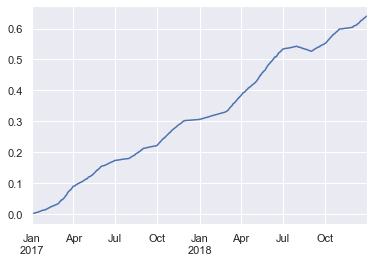

In [16]:
daily_df2['2017':].snow.cumsum().plot()

In [17]:
(daily_df2['pcp']/365.25).resample('a').sum().mean()

0.0974123743405029

In [18]:
dd4 = pd.read_pickle('TempAlter.pkl')
daily_df2['Tskin_dd4'] = daily_df2['Tskin']*(1-dd4['mm'].rolling(5).mean())
# daily_df2['Tskin_dd'] = daily_df2['Tskin']*(1+dd4['mm']*0.3)

In [19]:
daily_df2[((daily_df2.index.year>1985) & ((daily_df2.index.month==6) | (daily_df2.index.month==7) | (daily_df2.index.month==8)))].Tavg.mean() - 273.15
# daily_df2[((daily_df2.index.month==8))].Tavg.mean() - 273.15

-59.256126482213546

<AxesSubplot:>

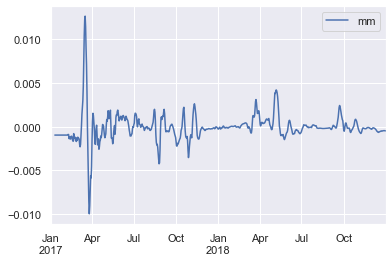

In [20]:
dd4.rolling(10).mean().plot()#['2017-06']

In [21]:
daily_df2['Tskin_dd4_box'] = daily_df2['Tskin_dd4'].rolling(5,win_type='hamming',center=True).mean()

<AxesSubplot:>

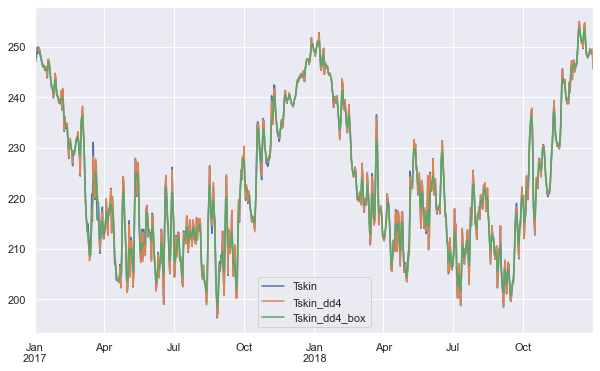

In [22]:
f1,a1=plt.subplots(figsize=(10,6))
daily_df2[['Tskin','Tskin_dd4','Tskin_dd4_box']]['2017':].plot(ax=a1)

In [23]:
daily_df2['Tskin_dd4_box'].iloc[-2:] = daily_df2['Tskin_dd4'].iloc[-2:]

In [24]:
# ddshift = pd.DataFrame({'tskin':daily_df2.Tskin_damp.values},index=daily_df2.index+pd.DateOffset(days=15))
# ddshift['decdate'] = ddshift.index.to_series().apply(toYearFraction).values
# ddshift.drop((ddshift.loc[ddshift.index > pd.to_datetime('2018-12-31')]).index,inplace=True)

<AxesSubplot:>

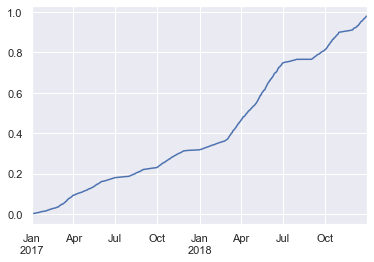

In [26]:
daily_df3 = daily_df2['2017':].copy()
daily_df3['pcp'][daily_df3['pcp']<0]=0
daily_df3['pcp']['2017']=daily_df3['pcp']['2017']*1.1
daily_df3['pcp']['2018':]=daily_df3['pcp']['2018':]*2
(daily_df3['pcp']['2017':]/365.25*917/340).cumsum().plot()

In [27]:
(daily_df3['pcp']/365.25*917/340).cumsum()

2017-01-01    0.000263
2017-01-02    0.001199
2017-01-03    0.001632
2017-01-04    0.002119
2017-01-05    0.002319
                ...   
2018-12-27    0.971018
2018-12-28    0.973459
2018-12-29    0.976716
2018-12-30    0.979219
2018-12-31    0.979627
Name: pcp, Length: 730, dtype: float64

In [28]:
cpc = (daily_df3['pcp']['2017':]/365.25*917/340).cumsum()

<AxesSubplot:>

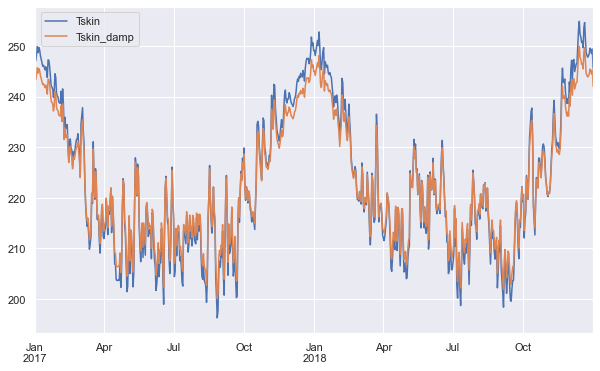

In [29]:
# %matplotlib notebook
f1,a1=plt.subplots(figsize=(10,6))
daily_df2['2017':][['Tskin','Tskin_damp']].plot(ax=a1)

In [30]:
daily_df3.Tskin_dd4_box = daily_df3.Tskin_dd4_box.bfill()

In [31]:
daily_df2.decdate

1958-01-01    1958.000000
1958-01-02    1958.002740
1958-01-03    1958.005479
1958-01-04    1958.008219
1958-01-05    1958.010959
                 ...     
2018-12-27    2018.986301
2018-12-28    2018.989041
2018-12-29    2018.991781
2018-12-30    2018.994521
2018-12-31    2018.997260
Name: decdate, Length: 22280, dtype: float64

In [71]:
%matplotlib inline

<AxesSubplot:>

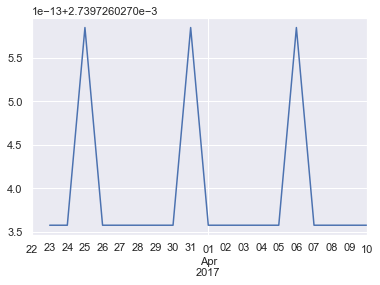

In [88]:
f1,a1=plt.subplots()
daily_df3[80:100].decdate.diff().plot(ax=a1)

In [86]:
daily_df3[80:90].decdate.diff().values[2]

0.002739726027357392

In [92]:
daily_df2["2017":].decdate[85]

2017.2328767123288

In [33]:
# use daily_df3 for the added accumulation to meet measurements. 
daily_df3[:'2018-12-24'].to_csv('/Users/maxstev/Documents/Grad_School/Research/FIRN/CFM/CommunityFirnModel/CFM_main/SouthPole/SP_daily_bdot1.csv',columns=['decdate','pcp'],header=False,index=False)
daily_df3[:'2018-12-24'].to_csv('/Users/maxstev/Documents/Grad_School/Research/FIRN/CFM/CommunityFirnModel/CFM_main/SouthPole/SP_daily_tskin_dd4_box.csv',columns=['decdate','Tskin_dd4_box'],header=False,index=False)

In [69]:
daily_df3.decdate[1]

2017.0027397260274

In [35]:
s2017 = np.cumsum(daily_df2['2017-01-01':'2017-12-31'].pcp/365.25*(917/300))

In [36]:
s2018 = s2017[-1]+np.cumsum((daily_df2['2018-01-01':'2018-12-31'].pcp*1.8)/365.25*(917/300))

In [37]:
snowseries = pd.concat((s2017,s2018))

In [38]:
hc = snowseries.reindex(pd.date_range(snowseries.index[0],snowseries.index[-1],freq='6H')).interpolate('linear')

In [39]:
hc[:'2018-12-24']

2017-01-01 00:00:00    0.000270
2017-01-01 06:00:00    0.000512
2017-01-01 12:00:00    0.000753
2017-01-01 18:00:00    0.000994
2017-01-02 00:00:00    0.001235
                         ...   
2018-12-23 18:00:00    0.952240
2018-12-24 00:00:00    0.953035
2018-12-24 06:00:00    0.953746
2018-12-24 12:00:00    0.954457
2018-12-24 18:00:00    0.955169
Freq: 6H, Name: pcp, Length: 2892, dtype: float64

In [40]:
hc[:'2018-12-24'].to_pickle('HeightChange_full.pkl')
# (hc['2017-02-05 12:00':'2018-12-24 18:00']).to_pickle('HeightChange.pkl')

In [41]:
newtimeindex = pd.date_range(snowseries.index[0],snowseries.index[-1],freq='6H')

In [42]:
daily_df2.Tavg.mean()
# daily_df2['2017-02-05':].Tavg.mean()

223.88830341113245

In [43]:
# ### Density
# '''
# getting the diameter wrong by 1mm adds ~2 percent error.
# Accumulation at pole is ~0.07 m W.E per year, or 64 kg/m^3 per year.
# Adds ~3.6% more stress to the ~4-5 m depth per year.
# '''
# rho126=np.genfromtxt('/Users/maxstev/Documents/Grad_School/Research/SouthPole/DATA/SPdensity_126.csv',delimiter=',',skip_header=1)
# dep126=rho126[:,0]
# den126=rho126[:,1]
# rho106=np.genfromtxt('/Users/maxstev/Documents/Grad_School/Research/SouthPole/DATA/SPdensity_106.csv',delimiter=',',skip_header=1)
# dep106=rho106[:,0]
# den106=rho106[:,1]*1000
# rhopit=np.genfromtxt('/Users/maxstev/Documents/Grad_School/Research/SouthPole/DATA/SPdensity_pit.csv',delimiter=',',skip_header=1)
# deppit=rhopit[:,0]
# denpit=rhopit[:,1]
# rhonic=np.genfromtxt('/Users/maxstev/Documents/Grad_School/Research/SouthPole/DATA/SPdensity_nicl.csv',delimiter=',',skip_header=1)
# depnic=rhonic[:,0]
# dennic=rhonic[:,1]

# dennic = np.append(290,dennic)
# depnic = np.append(0,depnic)

# densmooth = dennic.copy()
# N=3
# idr = int(np.floor(N/2))
# densmooth[idr:-idr] = np.convolve(dennic,np.ones((N,))/N, mode='valid')

# pitsmooth=denpit.copy()
# n2=7
# idr2 = int(np.floor(n2/2))
# pitsmooth[idr2:-idr2]=np.convolve(denpit,np.ones((n2,))/n2,mode='valid')
# pitsmooth[deppit<0.2] = np.mean(pitsmooth[deppit<0.2])
# # pitsmooth[0:idr2] = np.mean(pitsmooth[0:idr2])
# pitsmooth[-idr2:] = np.mean(pitsmooth[-idr2:])

In [44]:
usp_timescale = pd.read_csv('USP50_Timescale.csv')
usp_timescale['age'] = 2017 - usp_timescale.Year

In [45]:
rho126=np.genfromtxt('/Users/maxstev/Documents/Grad_School/Research/SouthPole/DATA/SPdensity_126.csv',delimiter=',',skip_header=1)
dep126=rho126[:,0]
den126=rho126[:,1]
rho106=np.genfromtxt('/Users/maxstev/Documents/Grad_School/Research/SouthPole/DATA/SPdensity_106.csv',delimiter=',',skip_header=1)
dep106=rho106[:,0]
den106=rho106[:,1]*1000
rhopit=np.genfromtxt('/Users/maxstev/Documents/Grad_School/Research/SouthPole/DATA/SPdensity_pit.csv',delimiter=',',skip_header=1)
deppit=rhopit[:,0]
denpit=rhopit[:,1]
rhonic=np.genfromtxt('/Users/maxstev/Documents/Grad_School/Research/SouthPole/DATA/SPdensity_nicl.csv',delimiter=',',skip_header=1)
depnic=rhonic[:,0]
dennic=rhonic[:,1]

dennic = np.append(290,dennic)
depnic = np.append(0,depnic)

densmooth = dennic.copy()
densmooth106 = den106.copy()
N=7
idr = int(np.floor(N/2))
densmooth[idr:-idr] = np.convolve(dennic,np.ones((N,))/N, mode='valid')
densmooth106[idr:-idr] = np.convolve(den106,np.ones((N,))/N, mode='valid')

pitsmooth=denpit.copy()
n2=7
idr2 = int(np.floor(n2/2))
pitsmooth[idr2:-idr2]=np.convolve(denpit,np.ones((n2,))/n2,mode='valid')
pitsmooth[deppit<0.2] = np.mean(pitsmooth[deppit<0.2])
# pitsmooth[0:idr2] = np.mean(pitsmooth[0:idr2])
pitsmooth[-idr2:] = np.mean(pitsmooth[-idr2:])

dep_int=np.arange(0,108.1,0.1)
rho_int = np.interp(dep_int,depnic,densmooth)
rho106_int = np.interp(dep_int,dep106,densmooth106)
rho_int_df = pd.DataFrame({'dep_int':dep_int,'rho_int':rho_int})

usp50_ts = pd.read_csv('USP50_Timescale_zero.csv')
usp50_ts['tau']=usp50_ts.BP-usp50_ts.BP[0]

USPintfun = sp.interpolate.interp1d(depnic,densmooth,fill_value='extrapolate')
usp50_ts['density'] = USPintfun(usp50_ts.Depth)
usp50_ts['mass'] = usp50_ts.Thickness*usp50_ts.density
usp50_ts['bdot_ie'] = usp50_ts.mass/917.0

usp50bdot1 = usp50_ts[['Year','bdot_ie']]
usp50bdot1.set_index('Year',inplace=True)
usp50bdot = usp50bdot1.reindex(index=usp50bdot1.index[::-1])

bdot_extend = np.concatenate((usp50bdot.to_numpy().T[0][:-1],np.array([0.1189,0.100,0.1093])))

bdot_long=np.tile(bdot_extend,(1,12)).flatten()

age_int = np.interp(dep_int,usp50_ts['Depth'].values,usp50_ts['tau'].values)
rho_int_df['age'] = age_int
rho_int_df['mass'] = rho_int_df['rho_int']*0.1

# usp50_ts.loc[1,'bdot_ie'] = 0.15
usp50_ts['bdot_mean'] = usp50_ts['bdot_ie'].cumsum()/usp50_ts['tau']
usp50_ts.loc[0,'bdot_mean'] = np.mean(usp50_ts.bdot_mean.iloc[1:11].mean())

In [46]:
usp50_ts

,Depth,BP,Year,Thickness,tau,density,mass,bdot_ie,bdot_mean
0,0.000000,-67,2017,0.000000,0,290.000000,0.000000,0.000000,0.135441
1,0.577866,-66,2016,0.577866,1,340.964109,197.031472,0.214865,0.214865
2,0.915818,-65,2015,0.337952,2,355.264192,120.062251,0.130929,0.172897
3,1.158721,-64,2014,0.242903,3,359.031127,87.209743,0.095103,0.146966
4,1.433307,-63,2013,0.274586,4,363.289401,99.754188,0.108783,0.137420
...,...,...,...,...,...,...,...,...,...
1017,109.344866,950,1000,0.056161,1017,801.103624,44.990731,0.049063,0.075722
1018,109.401027,951,999,0.056161,1018,800.090781,44.933849,0.049001,0.075696
1019,109.463428,952,998,0.062401,1019,798.965397,49.856274,0.054369,0.075675
1020,109.513349,953,997,0.049921,1020,798.065092,39.840075,0.043446,0.075643


In [47]:
dft5 = pd.read_pickle('dft5.pkl')
dft4 = pd.read_pickle('dft4.pkl')

In [48]:
depth_master = np.append(0,usp_timescale.Depth.values)
age_master = np.append(0,usp_timescale.age.values)

In [49]:
### Interpolate the temperature
temp_170205 = np.append(dft5.iloc[0].values,np.mean(dft5.iloc[0].values[-10:]))
therm_depths_170205 = np.append(dft4.depth[1:].values,depth_master[-1])
tfun = sp.interpolate.interp1d(therm_depths_170205, temp_170205, kind='slinear',fill_value = 'extrapolate')
t_interp = tfun(depth_master)

In [50]:
### Interpolate the density
denfun = sp.interpolate.interp1d(depnic,densmooth,kind='slinear',fill_value='extrapolate')
den_interp = denfun(depth_master)
den_interp[0:2] = 340

In [51]:
### Interpolate the density
denfun = sp.interpolate.interp1d(depnic,densmooth,kind='slinear',fill_value='extrapolate')
den_interp = denfun(depth_master)
den_interp[0:2] = 340

In [52]:
spin_df = pd.DataFrame({'depth':depth_master,'density':den_interp,'temperature':t_interp+273.15,'age':age_master,'bdot_mean':usp50_ts.bdot_mean})       

In [53]:
spin_df

,depth,density,temperature,age,bdot_mean
0,0.000000,340.000000,241.100000,0,0.135441
1,0.577866,340.000000,237.819683,1,0.214865
2,0.915818,355.264192,236.304584,2,0.172897
3,1.158721,359.031127,235.056396,3,0.146966
4,1.433307,363.289401,233.756789,4,0.137420
...,...,...,...,...,...
1017,109.344866,801.103624,222.089268,1017,0.075722
1018,109.401027,800.090781,222.089421,1018,0.075696
1019,109.463428,798.965397,222.089591,1019,0.075675
1020,109.513349,798.065092,222.089727,1020,0.075643


In [54]:
spin_df.to_csv('/Users/maxstev/Documents/Grad_School/Research/FIRN/CFM/CommunityFirnModel/CFM_main/SouthPole/SP_2017start.csv',index=False)  

In [55]:
spin_df

,depth,density,temperature,age,bdot_mean
0,0.000000,340.000000,241.100000,0,0.135441
1,0.577866,340.000000,237.819683,1,0.214865
2,0.915818,355.264192,236.304584,2,0.172897
3,1.158721,359.031127,235.056396,3,0.146966
4,1.433307,363.289401,233.756789,4,0.137420
...,...,...,...,...,...
1017,109.344866,801.103624,222.089268,1017,0.075722
1018,109.401027,800.090781,222.089421,1018,0.075696
1019,109.463428,798.965397,222.089591,1019,0.075675
1020,109.513349,798.065092,222.089727,1020,0.075643


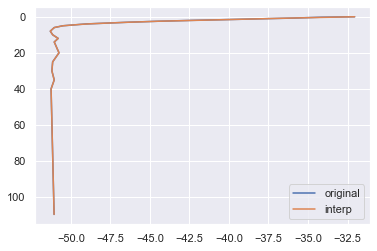

In [56]:
f1,a1 = plt.subplots()
a1.plot(temp_170205,therm_depths_170205,label='original')
a1.plot(t_interp,depth_master,label='interp')
a1.invert_yaxis()
a1.legend()

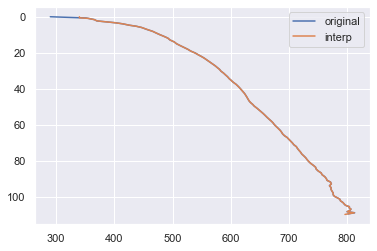

In [57]:
f1,a1 = plt.subplots()
a1.plot(densmooth,depnic,label='original')
a1.plot(den_interp,depth_master,label='interp')
a1.invert_yaxis()
a1.legend()

In [58]:
%matplotlib notebook
f2,a2=plt.subplots(figsize=(9,9))
# a2.plot(den126,dep126)
a2.plot(den106,dep106,label='106')

a2.plot(pitsmooth,deppit,label='pitsmooth')
a2.plot(densmooth,depnic,label='smooth')
a2.plot(dennic,depnic,label='NICL')
# a2.set_ylim(0,4)
a2.invert_yaxis()
a2.legend()

<IPython.core.display.Javascript object>

In [59]:
f1,a1 = plt.subplots()
a1.plot(monthly_df.index,monthly_df.tskin)

<IPython.core.display.Javascript object>

In [60]:
spinyears = 1200
dates = monthly_df.index + pd.Timedelta('14D')
st_year = dates.year[0] - spinyears
date_end = 2018
months = dates[0:12].to_pydatetime()
helper = np.vectorize(lambda x: x.timetuple().tm_yday)
decis = (helper(months)-0.5)/365

yrvec = np.arange(st_year,st_year+spinyears)
yrtile = np.tile(yrvec[...,None],[1,12])
allspintime = yrtile + decis
allspintime_vec = np.ndarray.flatten(allspintime)

yrvec2 = np.arange(dates.year[0],date_end+1)
yrtile2 = np.tile(yrvec2[...,None],[1,12])
allspintime2 = yrtile2 + decis
allspintime2_vec = np.ndarray.flatten(allspintime2)

time_out = np.concatenate((allspintime_vec,allspintime2_vec))

In [62]:
tileyears = 25
reps = spinyears/tileyears
tskin_rep = np.tile(monthly_df.tskin.iloc[0:tileyears*12].values,int(reps))
bdot_rep = np.tile(monthly_df.bdotIE.iloc[0:tileyears*12].values,int(reps))
tskin_long = np.concatenate((tskin_rep,monthly_df.tskin.values))
bdot_long = np.concatenate((bdot_rep,monthly_df.bdotIE.values))
bdot_long[bdot_long<0] = 0.005
bdot_con = np.mean(bdot_long)*np.ones_like(bdot_long)
tskin_out = np.array((time_out,tskin_long))
bdot_out = np.array((time_out,bdot_long))
bdot_con_out = np.array((time_out,bdot_con))

In [63]:
monthly_df.tskin.iloc[0:tileyears*12]

date
1958-01-31   -26.556834
1958-02-28   -37.256834
1958-03-31   -55.656834
1958-04-30   -63.756834
1958-05-31   -58.456834
                ...    
1982-08-31   -63.356834
1982-09-30   -62.956834
1982-10-31   -50.456834
1982-11-30   -33.956834
1982-12-31   -28.656834
Freq: M, Name: tskin, Length: 300, dtype: float64

In [64]:
f1,a1=plt.subplots()
a1.plot((tskin_out[0,:]-2018),tskin_out[1,:])

<IPython.core.display.Javascript object>

In [ ]:
f1,a1=plt.subplots()
a1.plot((bdot_out[0,:]-2018),bdot_out[1,:])

In [ ]:
np.savetxt('/Users/maxstev/Documents/Grad_School/Research/FIRN/CFM/CommunityFirnModel/CFM_main/SouthPole/SP_tskin_long.csv',tskin_out,delimiter=',',fmt='%1.4f')
# np.savetxt('/Users/maxstev/Documents/Grad_School/Research/FIRN/CFM/CommunityFirnModel/CFM_main/SouthPole/SP_bdot_long.csv',bdot_out,delimiter=',',fmt='%1.4f')
np.savetxt('/Users/maxstev/Documents/Grad_School/Research/FIRN/CFM/CommunityFirnModel/CFM_main/SouthPole/SP_bdot_long_pos.csv',bdot_out,delimiter=',',fmt='%1.4f')
np.savetxt('/Users/maxstev/Documents/Grad_School/Research/FIRN/CFM/CommunityFirnModel/CFM_main/SouthPole/SP_bdot_long_con.csv',bdot_con_out,delimiter=',',fmt='%1.4f')

In [ ]:
cfm_results=h5.File('/Users/maxstev/Documents/Grad_School/Research/FIRN/CFM/CommunityFirnModel/CFM_main/SP_test/CFMresults.hdf5','r')
modeltime = cfm_results['depth'][-24:,0]
dep = cfm_results['depth'][-24:,1:]
rho = cfm_results['density'][-24:,1:]
age =  cfm_results['age'][1:]
temp = cfm_results['temperature'][-24:,1:]
# rd3[fn]['DIP'] = cfm_results['DIP'][1:,1:]
# ddh3[fn] = rd3[fn]['DIP'][:,2]
# fcd3[fn] = rd3[fn]['DIP'][:,3]
cfm_results.close()

In [ ]:
%matplotlib notebook
f1,a1=plt.subplots(figsize=(11,9))
a1.plot(rho[0,:],age)
a1.invert_yaxis()

In [ ]:
f1,a1=plt.subplots(figsize=(11,9))
a1.plot(rho[0,:],dep[0,:])
a1.plot(den106,dep106)
a1.plot(denpit,deppit)
a1.invert_yaxis()

In [ ]:
depths = dft4.depth[1:].values
tprof170215 = dft5.iloc[38].values

In [ ]:
f1,a1 = plt.subplots(figsize = (8,8))
a1.plot(tprof170215,depths,label = 'data')
a1.plot(temp[2,1:]-273.15,dep[2,1:],label = 'model')
a1.set_ylim(-1,40)
a1.invert_yaxis()


# Compare daily vs monthly model results

In [ ]:
fn_d = '/Users/maxstev/Documents/Grad_School/Research/FIRN/CFM/CommunityFirnModel/CFM_main/SP_test_daily/CFMresults.hdf5'
fn_m = '/Users/maxstev/Documents/Grad_School/Research/FIRN/CFM/CommunityFirnModel/CFM_main/SP_test_monthly/CFMresults.hdf5'

In [ ]:
f = h5.File(fn_d,'r')
time_d = f['temperature'][1:,0]
# i2007 = np.where(time_model>2007.45)[0][0]
# temp_2007 = f['temperature'][i2007,1:]
dep_d = f['depth'][1:,1:]
rho_d = f['density'][1:,1:]
DIP_d = f['DIP'][1:,1:]
dcon_d = f['Dcon'][1:,1:]
f.close()

f = h5.File(fn_m,'r')
time_m = f['temperature'][1:,0]
# i2007 = np.where(time_model>2007.45)[0][0]
# temp_2007 = f['temperature'][i2007,1:]
dep_m = f['depth'][1:,1:]
rho_m = f['density'][1:,1:]
DIP_m = f['DIP'][1:,1:]
dcon_m = f['Dcon'][1:,1:]
f.close()

In [ ]:
daily_df2['2017-02-05':]

In [ ]:
daily_results=pd.DataFrame(data=DIP_d[:,0:4],columns=['DIP','DH','DHc','comp'],index=daily_df2['2017-02-06':].index)

In [ ]:
daily_results.index.get_loc('2017-02-28')

In [ ]:
f1,a1=plt.subplots()
# a1.plot(time_d[1:],DIP_d[1:,3])
a1.plot(time_m[:],DIP_m[:,2])
a1.plot(time_d[:],(DIP_d[:,2]-DIP_d[22,2]))

In [ ]:
f1,a1=plt.subplots()
# a1.plot(time_d[1:],DIP_d[1:,3])
a1.plot(time_m[:],DIP_m[:,2])
a1.plot(time_d[:],(DIP_d[:,2]-DIP_d[22,2]))

In [ ]:
f1,a1=plt.subplots()
# a1.plot(time_d[1:],DIP_d[1:,3])
a1.plot(time_m[1:],DIP_m[1:,3]/np.mean(np.diff(time_m)))
a1.plot(time_d[1:],DIP_d[1:,3]/np.mean(np.diff(time_d)))
# a1.plot(time_m[:-1],daily_results.comp.resample('M').sum().values[1:])

In [ ]:
f1,a1=plt.subplots()
# a1.plot(time_d[1:],DIP_d[1:,3])
a1.plot(time_m[:-1],np.cumsum(DIP_m[1:,3]))
a1.plot(time_m[:-1],np.cumsum(daily_results.comp.resample('M').sum().values[1:]))

In [ ]:
f1,a1=plt.subplots()
# a1.plot(time_d[1:],DIP_d[1:,3])
# a1.plot(time_m[:-1],DIP_m[1:,3])
a1.plot(time_m[:-1],(daily_results.comp.resample('M').sum().values[1:]-DIP_m[1:,3])/1e-3)

In [ ]:
f2,a2=plt.subplots()
daily_results[1:].comp.plot(ax=a2)

In [ ]:
ddf2017 = daily_df2['2017-02-05':]
f3,a3 = plt.subplots()
ddf2017.Tavg.plot(ax=a3)
a3b = a3.twinx()
ddf2017.pcp.plot(ax=a3b,color='r')

In [ ]:
def find_indices(points,lon,lat,tree=None):
    if tree is None:
        # lon,lat = lon.T,lat.T
        lonlat = np.column_stack((lon.ravel(),lat.ravel()))
        tree = cKDTree(lonlat)
    dist,idx = tree.query(points,k=[1])
    ind = np.column_stack(np.unravel_index(idx,lon.shape))
    print(ind)
    for i,j in ind:
        ii=i
        jj=j
    # return [(i,j) for i,j in ind]
    return ii,jj #, [(i,j) for i,j in ind]

In [ ]:
from scipy.spatial import cKDTree
import netCDF4 as nc

In [ ]:

fn_t2m = "/Volumes/Samsung_T1/RACMO/Antarctica/t2m.KNMI-2011.ANT27.ERAINx_RACMO2.4.1.DD.nc"
fn_tskin = "/Volumes/Samsung_T1/RACMO/Antarctica/tskin.KNMI-2011.ANT27.ERAINx_RACMO2.4.1.DD.nc"
lat_int = -89.54 #south pole
lon_int = 137.04
nc_t2m = nc.Dataset(fn_t2m, 'r') 
lat = nc_t2m.variables['lat'][:]
lon = nc_t2m.variables['lon'][:]
time_t2m = nc_t2m.variables['time'][:]
ii=117
jj=135
t2m_in = nc_t2m.variables['t2m'][:].data[:,0,ii,jj]
nc_t2m.close()
nc_tskin = nc.Dataset(fn_tskin, 'r') 
tskin_in = nc_tskin.variables['tskin'][:].data[:,0,ii,jj]
nc_tskin.close()
# ii,jj = find_indices((lon_int,lat_int),lon,lat)
# print(ii,jj)
# print(lat[ii,jj])
# print(lon[ii,jj])
racmodate = [pd.datetime(1950,1,1) + pd.Timedelta(time_t2m.data[ii],unit='d') for ii in range(len(time_t2m.data))]

In [ ]:
racT_df = pd.DataFrame({'tskin':tskin_in,'t2m':t2m_in},index=racmodate)

In [ ]:
racT_df.describe()

In [ ]:
f1,a1=plt.subplots(figsize=(18,6))
(racT_df['2011-07']['t2m']).plot(ax=a1,label='t2m')
(racT_df['2011-07']['t2m']*0.985).plot(ax=a1,label='t2m scale')
(racT_df['2011-07']['tskin']).plot(ax=a1,label='tskin')
a1.legend()

In [ ]:
df2 = racT_df.copy()
df2['Tdiff'] = df2.tskin-df2.t2m
df2['Tper'] = (df2.tskin-df2.t2m)/df2.t2m
df2.drop([df2.iloc[424].name,df2.iloc[1885].name],inplace=True) # get rid of the leap days


In [ ]:
for jj,yr in enumerate(df2.index.year.unique()):
    if jj == 0:
        df3 = pd.DataFrame({'tper{}'.format(yr):df2[str(yr)]['Tper'].values},index=df2[str(yr)].index.dayofyear)
    else:
        df3['tper{}'.format(yr)] = df2[str(yr)]['Tper'].values

In [ ]:
df3['Pmean']=df3.mean(axis=1)

In [ ]:
f1,a1=plt.subplots(figsize=(8,6))
df3['Pmean'].plot(ax=a1)

In [ ]:
df2.index.year.unique()

In [ ]:
df4=pd.DataFrame({'Tdata':df2.Tper.values})
# df4=pd.DataFrame({'Tdata':(df2['Tdiff']-df2['Tdiff'].mean()).values})
df4['smooth'] = df4.Tdata.rolling(30,center=True).mean()

In [ ]:
from scipy import optimize
def test_func(x, a, b,c,d):
    return a * np.sin(b * x + c) + d
params, params_covariance = optimize.curve_fit(test_func, df4.index.values, df4.Tdata.values,p0=[0.1,np.pi*2/365,35,-0.01])

def tscaler(doy):
    a = -5.70493675e-03
    b = 1.72479759e-02
    c = 3.60427452e+01
    d = -9.41404759e-03
    return (a * np.sin(b * doy + c) + d) + 1

In [ ]:
tscaler(180)+1

In [ ]:
params

In [ ]:
ev=365*5
f1,a1=plt.subplots(figsize=(18, 8))
a1.plot(df4.index.values[0:ev], df4.Tdata.values[0:ev], label='Data')
a1.plot(df4.index.values[0:ev], df4.smooth.values[0:ev], label='Data')
a1.plot(df4.index.values[0:ev], test_func(df4.index.values[0:ev], params[0], params[1],params[2],params[3]),label='Fitted function')
a1.legend()

In [ ]:
df4

In [ ]:
f1,a1=plt.subplots(figsize=(18,6))
(df2['Tdiff']-df2['Tdiff'].mean()).plot(ax=a1)

In [ ]:
f1,a1=plt.subplots(figsize=(18,6))
(df2['Tper']).plot(ax=a1)

In [ ]:
df2.index.dayofyear

In [ ]:
np.where((df2.index.month==2)&(df2.index.day==29))[0]

In [ ]:
df2.iloc[424].name

In [ ]:
df2.drop([df2.iloc[424].name,df2.iloc[1885].name],inplace=True)

In [ ]:
df2['2012-02-20':'2012-03-02']

In [ ]:
t109_df = pd.read_pickle('T109data.pkl')
t109_df['K2'] = t109_df['Tbox2']+273.15
t109_df['K1'] = t109_df['Tbox1']+273.15

In [ ]:
t109_df

In [ ]:
daily_df2

In [ ]:
racT_df

In [ ]:
%matplotlib inline

In [ ]:
rac2=racT_df.copy()
rac2.index=rac2.index+pd.DateOffset(years=2)

In [ ]:

f1,a1 = plt.subplots(figsize=(18,8))
t109_df.K2.plot(ax=a1,label='T109')
t109_df.K1.plot(ax=a1,label='T109_1')
daily_df2.Tavg['2017':].plot(ax=a1,label='Tavg')
daily_df2.Tskin_damp['2017':].plot(ax=a1,label='damp')
rac2.tskin['2017':].plot(ax=a1,label='RACMO')
a1.legend()